## Extra Analysis

This notebook contains analyses and visualizations that I thought were interesting but of less direct relevance to the programming task.  
So in an attempt to avoid overloading the main notebook with too much information I moved the less relevant work to this notebook.  

Ideas for Further Work:  
create script for quick data cleaning  
Analyize topics on a monthly granularity  
Scrape newer reviews to see how they have changed in recent time  
Predict rating based on comment text  
If more data you could break down analysis per company to get more targeted feedback  
Analyze ngrams per comment instead of overall

### Imports

In [1]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt

from nltk.corpus import stopwords
from collections import defaultdict
from utils import (pretty_print_row, extract_company, clean_rating, generate_ngrams, plot_ngrams)

print('Imports Complete')

Imports Complete


### Ingest and Data Cleaning

In [2]:
# Reading Data
df = pd.read_json('./data/train_reviews.json')
print(df.info())

df['rating'] = df.stars.apply(lambda x: clean_rating(x)).astype('int32')
df['company'] = df['url'].apply(lambda x: extract_company(x))
df['year'] = df['date'].apply(lambda x: x.year)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2021 entries, 0 to 2020
Data columns (total 5 columns):
date     2021 non-null datetime64[ns, UTC]
title    2021 non-null object
text     2021 non-null object
url      2021 non-null object
stars    2021 non-null object
dtypes: datetime64[ns, UTC](1), object(4)
memory usage: 47.4+ KB
None


### Investigating Comment Length

In [3]:
# Extracting comment length as a feature
df['text_length'] = df['text'].apply(lambda x: len(x))
print(df.text_length.value_counts())

440     42
35      30
199     26
72      25
89      25
        ..
326      1
668      1
329      1
667      1
2019     1
Name: text_length, Length: 702, dtype: int64


<AxesSubplot:>

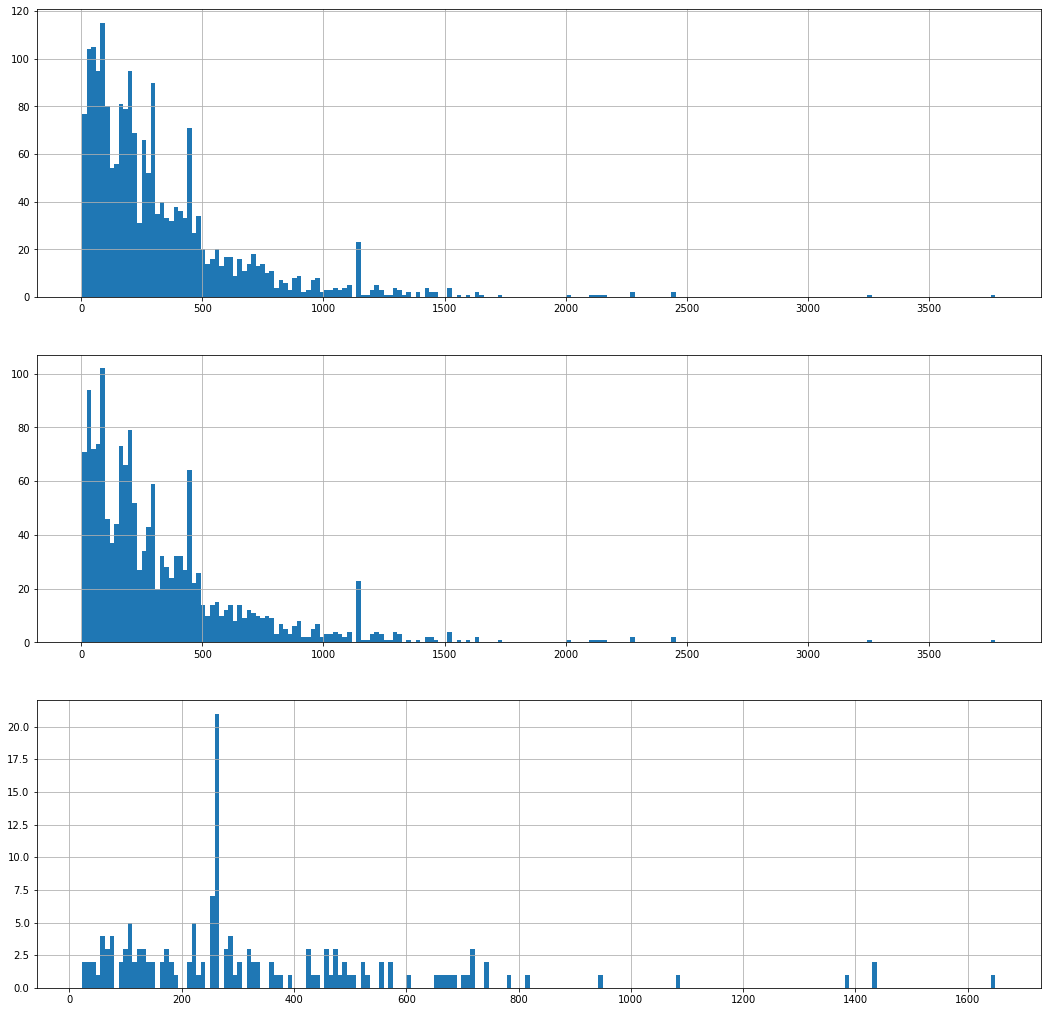

In [4]:
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(18,18))

df['text_length'].hist(ax=ax[0], bins=200)
df[df['stars'] == 'star-rating star-rating-1 star-rating--medium']['text_length'].hist(ax=ax[1], bins=200)
df[df['stars'] == 'star-rating star-rating-5 star-rating--medium']['text_length'].hist(ax=ax[2], bins=200)

In [5]:
# Long comments overwhelmingly negative
print(df['rating'].mean())
print(df[df['text_length'] >= 1000]['rating'].mean())

1.5338941118258287
1.2549019607843137


In [6]:
length_sorted_df = df[df['stars'] == 'star-rating star-rating-1 star-rating--medium'].sort_values(by=['text_length'], ascending=False)
pretty_print_row(length_sorted_df, 0)

Date: 2018-04-29 16:55:18+00:00
Title: Virgin what has happened to you?
Text: A very bad experience with Virgin staff who were less than helpful. After waiting 2 hours in the freezing cold station at Glasgow where actual snow flakes were coming through the roof our train back to London Euston flashed up cancelled. I asked the Virgin staff what should we do and the only advice given by a truly fed up female member of their staff was to download their train app and twitter for live updates. When asked but we are now stranded the female shrugged her shoulders put her arms out and said frostily "nothing I can do"! We were "abandoned" for 4 days without an offer of them finding accommodation, food or drink.....yet they had a duty of care which they failed dismally to provide. Their tweets advised each day that trains would leave Glasgow yet when you looked on Euston they were ALL cancelled and I had to tweet them to say their live updates were in fact incorrect. We discovered by mere chance

### Investigating Duplicates

In [19]:
# Investigating possible duplicates
# Based on spike in 5 star reviews lengths and weird behavior in trigrams 

anomalies = df[df['stars'] == 'star-rating star-rating-5 star-rating--medium']
anomalies = anomalies[df['text_length'] == 259]
    
da_df = df[df['title'] == 'Disabled assistance']
print(da_df.shape)
print(anomalies.shape)

# 1 star review duplicates
one_star_anomalies = df[df['stars'] == 'star-rating star-rating-1 star-rating--medium']

one_star_anomalies = df[df['text_length'] == 1153]
print(one_star_anomalies['date'].iloc[0])

# for i in range(one_star_anomalies.shape[0]):
#     pretty_print_row(one_star_anomalies, i)

# Drop duplicates?

(21, 9)
(21, 9)
2018-07-11 08:41:10+00:00


<ipython-input-19-a71201fb6d73>:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  anomalies = anomalies[df['text_length'] == 259]


In [8]:
# Exploring duplicates more
duplicated_df = df[df.duplicated(subset=['date', 'title', 'text', 'stars'], keep='first') == True]
print(duplicated_df.date.value_counts())
print(duplicated_df.shape)

single_date_df = df[df['date'] == '2018-04-16 14:33:59+00:00']
print(single_date_df.shape)
for i in range(single_date_df.shape[0]):
    pretty_print_row(single_date_df, i)
    
clean_df = df.drop_duplicates(subset=['date', 'title', 'text', 'stars'], keep='first')
print(df.shape)
print(clean_df.shape)

2018-05-07 09:52:57+00:00    20
2018-06-20 11:21:44+00:00    20
2018-03-31 14:11:54+00:00    20
2018-07-01 21:58:09+00:00    20
2018-06-06 05:19:27+00:00    20
                             ..
2018-01-30 19:30:14+00:00     1
2018-04-16 14:33:59+00:00     1
2018-02-03 08:59:40+00:00     1
2018-06-17 07:12:09+00:00     1
2018-07-08 20:55:03+00:00     1
Name: date, Length: 200, dtype: int64
(580, 9)
(2, 9)
Date: 2018-04-16 14:33:59+00:00
Title: Amazing
Text: Amazing! Marcus Garvey super helpful and efficient! Thank you so much for dealing with my case so effectively!
URL: https://uk.trustpilot.com/review/www.virgintrainseastcoast.com?page=1
Stars: star-rating star-rating-5 star-rating--medium
Date: 2018-04-16 14:33:59+00:00
Title: Amazing
Text: Amazing! Marcus Garvey super helpful and efficient! Thank you so much for dealing with my case so effectively!
URL: https://uk.trustpilot.com/review/www.virgintrainseastcoast.com
Stars: star-rating star-rating-5 star-rating--medium
(2021, 9)
(1441, 

## Plotting topics(ngrams) per company(Top 4 ~ 80% of data)

Plotting and analyzing the ngrams of the top 4 companies to investigate differences in topics on a company level.

(500, 9)


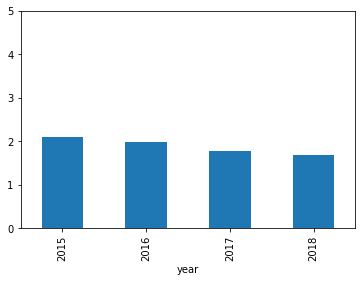

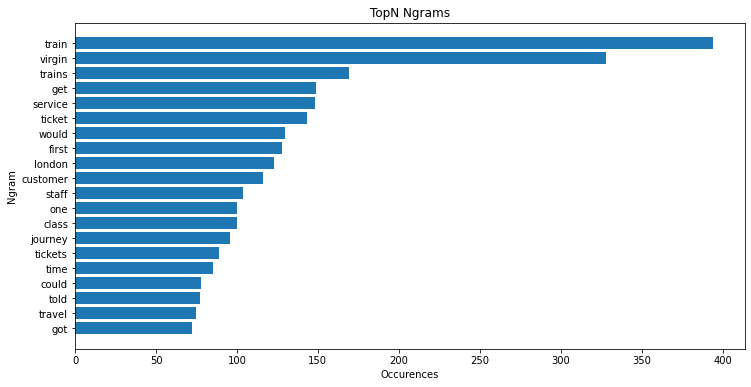

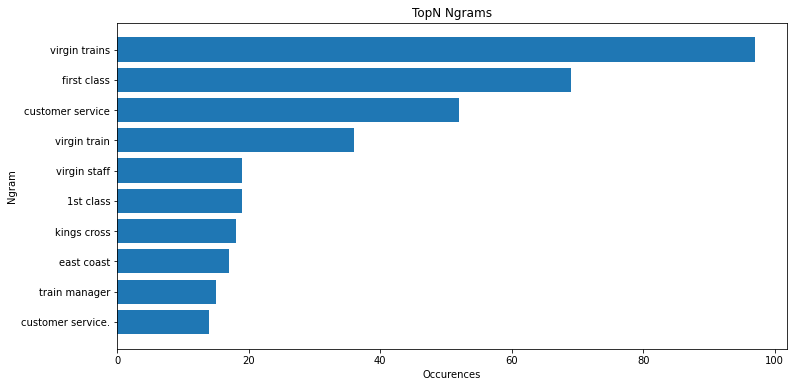

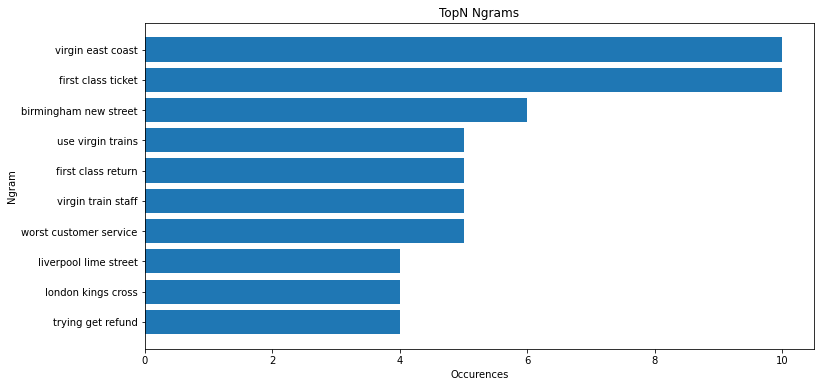

In [15]:
company_df = df[df['company'] == 'www.virgintrains.co.uk']
print(company_df.shape)
plt.ylim(0,5)
df[df['company'] == 'www.virgintrains.co.uk'].groupby('year')['rating'].mean().plot(kind='bar')
plot_ngrams(company_df, 1, 20, (12, 6))
plot_ngrams(company_df, 2, 10, (12, 6))
plot_ngrams(company_df, 3, 10, (12, 6))

(280, 9)


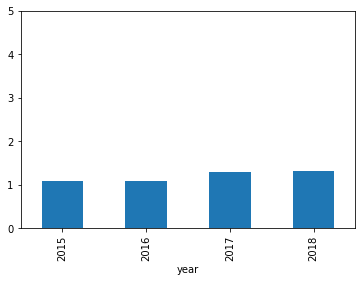

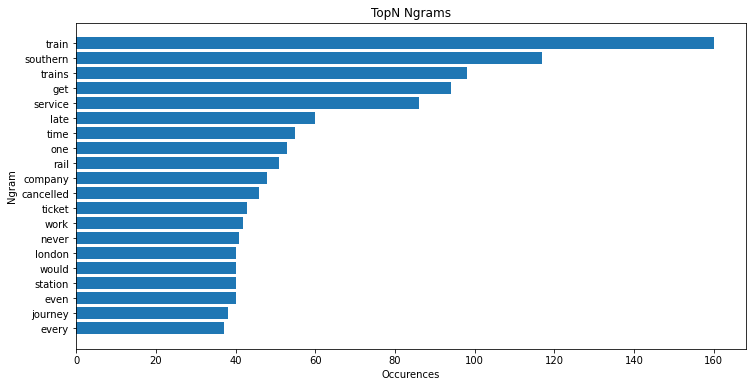

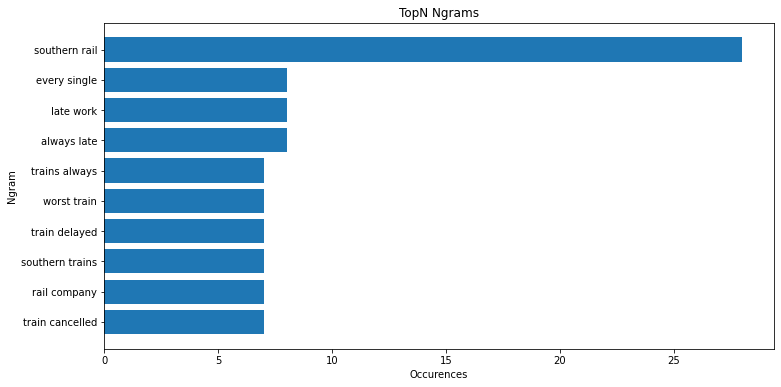

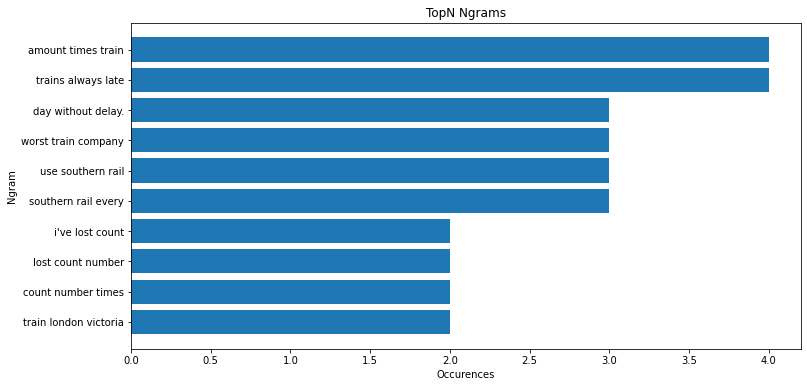

In [16]:
company_df = df[df['company'] == 'www.southernrailway.com']
print(company_df.shape)
plt.ylim(0,5)
df[df['company'] == 'www.southernrailway.com'].groupby('year')['rating'].mean().plot(kind='bar')
plot_ngrams(company_df, 1, 20, (12, 6))
plot_ngrams(company_df, 2, 10, (12, 6))
plot_ngrams(company_df, 3, 10, (12, 6))

(200, 9)


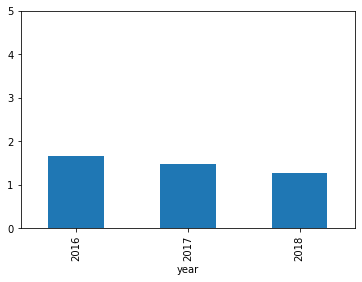

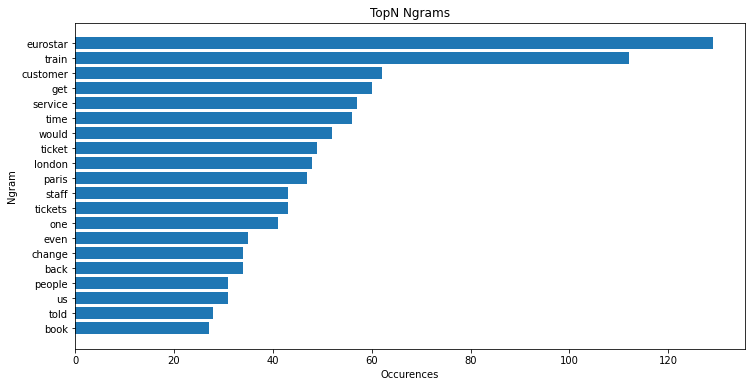

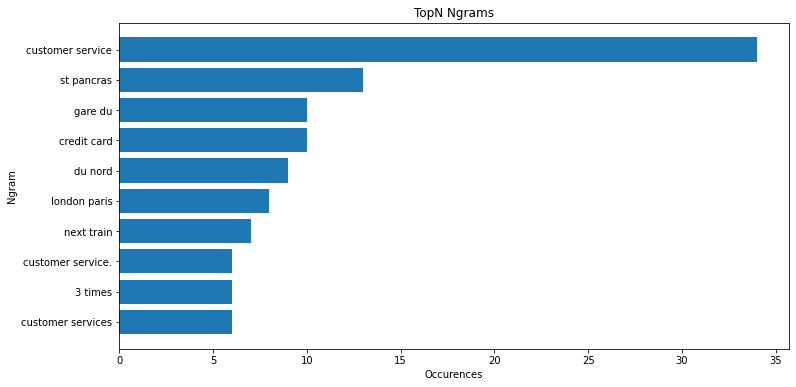

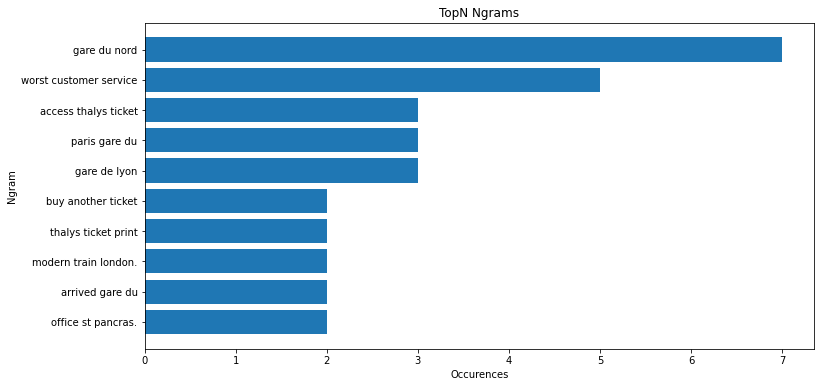

In [17]:
company_df = df[df['company'] == 'www.eurostar.com']
print(company_df.shape)
plt.ylim(0,5)
df[df['company'] == 'www.eurostar.com'].groupby('year')['rating'].mean().plot(kind='bar')
plot_ngrams(company_df, 1, 20, (12, 6))
plot_ngrams(company_df, 2, 10, (12, 6))
plot_ngrams(company_df, 3, 10, (12, 6))

(200, 9)


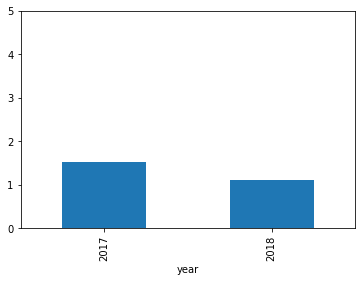

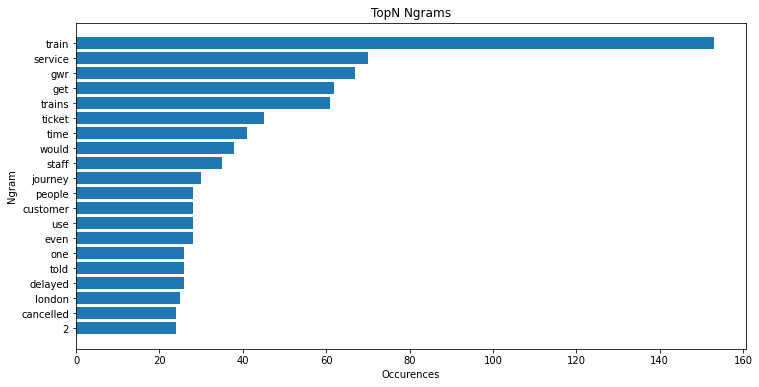

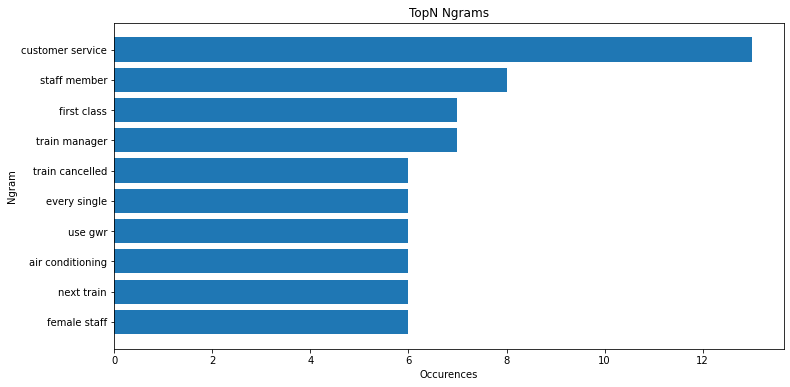

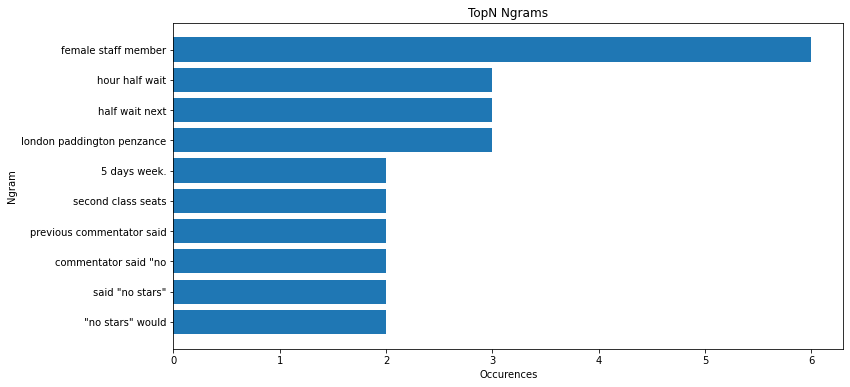

In [18]:
company_df = df[df['company'] == 'www.gwr.com']
print(company_df.shape)
plt.ylim(0,5)
df[df['company'] == 'www.gwr.com'].groupby('year')['rating'].mean().plot(kind='bar')
plot_ngrams(company_df, 1, 20, (12, 6))
plot_ngrams(company_df, 2, 10, (12, 6))
plot_ngrams(company_df, 3, 10, (12, 6))

Overall the review topics are very similar between companies with customer service continually being the top comment for most companies.  
The one major exception being southernrailway whose topn ngrams are dominated by scheduling topics like 'train always late', 'train delayed', 'train cancelled', and 'always late'  
From these trends I would estimate that southerrailway has significantly higher train delays and cancellations than the other companies.  

## Plotting topics(ngrams) in positive vs negative

Finally I wanted to briefly investigate the difference in topics between positive(4 and 5 star) reviews and negative(1 and 2 star) reviews to get an idea of which topics are more closely correlated to compliments and which are more often complaints.  

(222, 9)


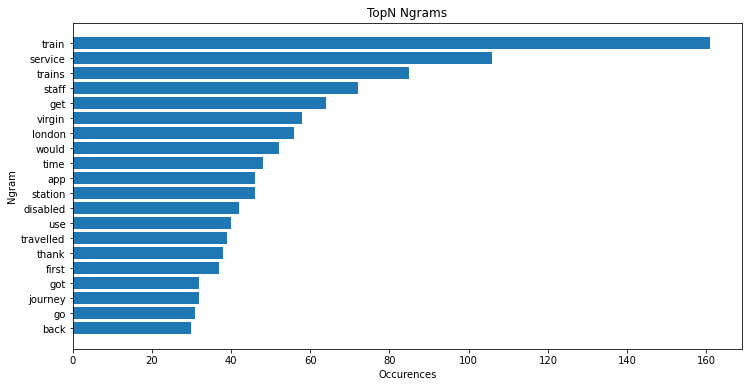

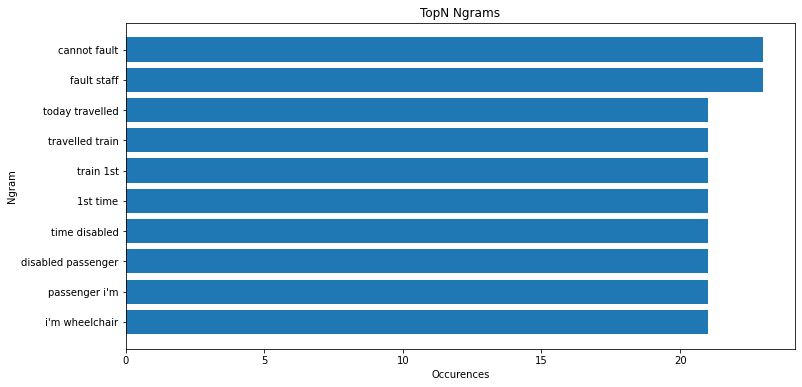

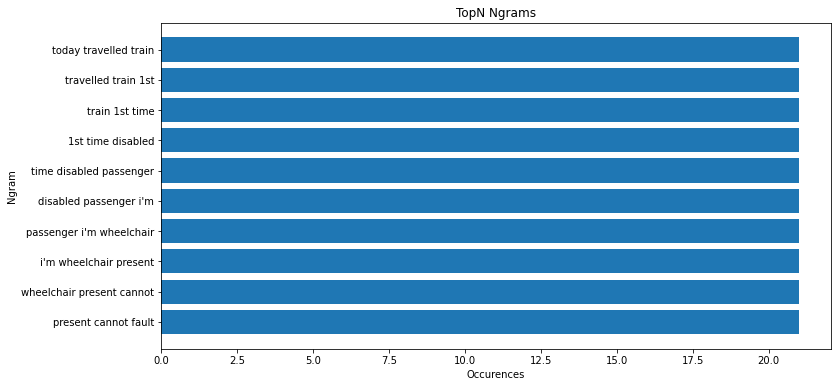

In [13]:
# Postive ngrams
positive_df = df[(df['rating'] == 5) | (df['rating'] == 4)]
print(positive_df.shape)
plot_ngrams(positive_df, 1, 20, (12, 6))
plot_ngrams(positive_df, 2, 10, (12, 6))
plot_ngrams(positive_df, 3, 10, (12, 6))

(1737, 9)


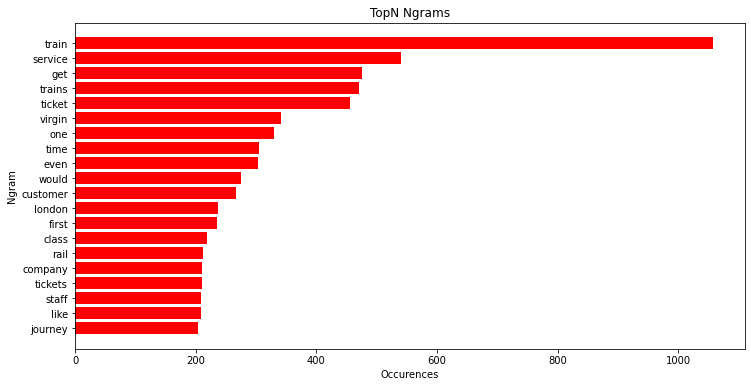

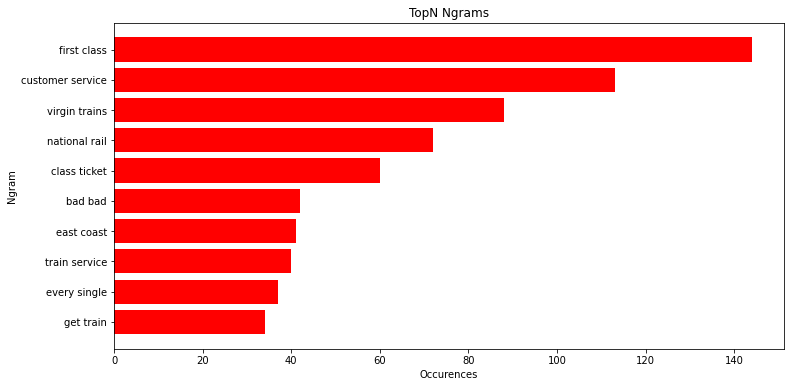

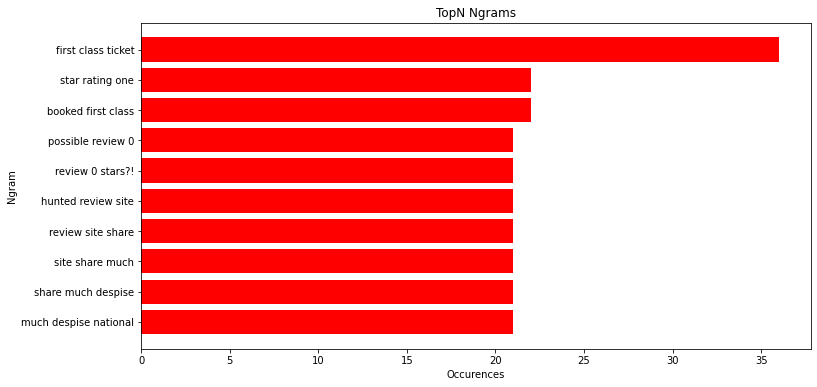

In [14]:
# Negative ngrams
negative_df = df[(df['rating'] == 1) | (df['rating'] == 2)]
print(negative_df.shape)
plot_ngrams(negative_df, 1, 20, (12, 6), color='r')
plot_ngrams(negative_df, 2, 10, (12, 6), color='r')
plot_ngrams(negative_df, 3, 10, (12, 6), color='r')

Unfortunately it is difficult to extract many meaningful insights here as the positive and negative ngrams are strikingly similar in terms of common topics.  
One interesting note is that 'customer service' and 'first class' show up commonly as both a compliment and a complaint.  
This shows that these are topics that the companies/client should definitely focus on as when the customer service or first class experience is positive it can have a huge positive impact on the customer experience and vice versa when the experience is negative or not up to expectations.